# DATA SCIENCE CON DOLIBARR PARA PYMES: SEGMENTACIÓN DE CLIENTES Y PREDICCIÓN DE FUGAS

# 0. PASOS PREVIOS

## 0.1 INTRODUCCIÓN

Cada vez es más habitual que las empresas cuenten con herramientas de gestión que les permitan organizar su información y digitalizarla para optimizar sus procesos, sin embargo la información almacenada en los SAP y ERP no siempre puede aprovecharse desde estas mismas herramientas, bien por falta de la tecnología necesaria, o por errores en la sistematización de la organización de esta información.

La Ciencia de Datos y el Machine Learning son disciplinas aplicables a todo tipo de orgnaizaciones, con independencia de su tamaño y actividad, por lo que su desarrollo en sinergia con las herramientas de gestión de la información facilitadas por los ERP y/o SAP, pueden suponer una importante ventaja competitiva. 

Dolibarr es uno de los ERP más utilizados en Pequeñas y Medianas empresas en España y Latinoamérica, sin embargo no cuenta con las prestaciones técnicas necesaria para desarrollar Machine Learning o Data Analysis de forma endógena, haciendo necesario un trabajo posterior como el realizado en este proyecto.


## 0.2 OBJETIVOS

1. Realizar análisis de Datos de la información extraída
2. Modelo predictivo de ventas y pedidos

### CARGA DE LIBRERIAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import plot_tree
from datetime import date
import seaborn as sn
import json
from IPython.display import Image
import cufflinks as cf
from IPython.display import display,HTML
import seaborn as sns
import folium
import cufflinks as cf
from IPython.display import display,HTML
import plotly.express as px
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans


%matplotlib inline

In [2]:
!pip install streamlit

### CARGA DE FUNCIONES

In [3]:
def EDA_inicial(DF):
    a = DF.shape
    b = DF.describe()
    c = DF.info()
    print("Info:\n",c,"\n")
    print("Shape:\n",a, "\n")
    print("Estadisticos:\n",b,"\n")

In [4]:
def graficos_eda_categoricos(cat):
    
    #Calculamos el número de filas que necesitamos
    from math import ceil
    filas = ceil(cat.shape[1] / 2)

    #Definimos el gráfico
    f, ax = plt.subplots(nrows = filas, ncols = 2, figsize = (16, filas * 6))

    #Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
    ax = ax.flat 

    #Creamos el bucle que va añadiendo gráficos
    for cada, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[cada])
        ax[cada].set_title(variable, fontsize = 12, fontweight = "bold")
        ax[cada].tick_params(labelsize = 12)

In [5]:
def estadisticos_cont(num):
    #Calculamos describe
    estadisticos = num.describe().T
    #Añadimos la mediana
    estadisticos['median'] = num.median()
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [6]:
def atributos_fechas(x):
    x['año'] = x.index.year
    x['mes'] = x.index.month_name()
    x['dia_mes'] = x.index.day
    x['dia_semana'] = x.index.day_name()
    x['hora'] = x.index.hour
    return(x)

# 1. EXTRACCIÓN DE DATOS

Doolibar cuenta con un sistema de exportación que hace muy sencilla la extracción de información en formato CSV o XLSX, permitiendo además aplicar filtros a cada uno de los valores exportados, lo que reducirá la necesidad de tratamiento de información posterior.

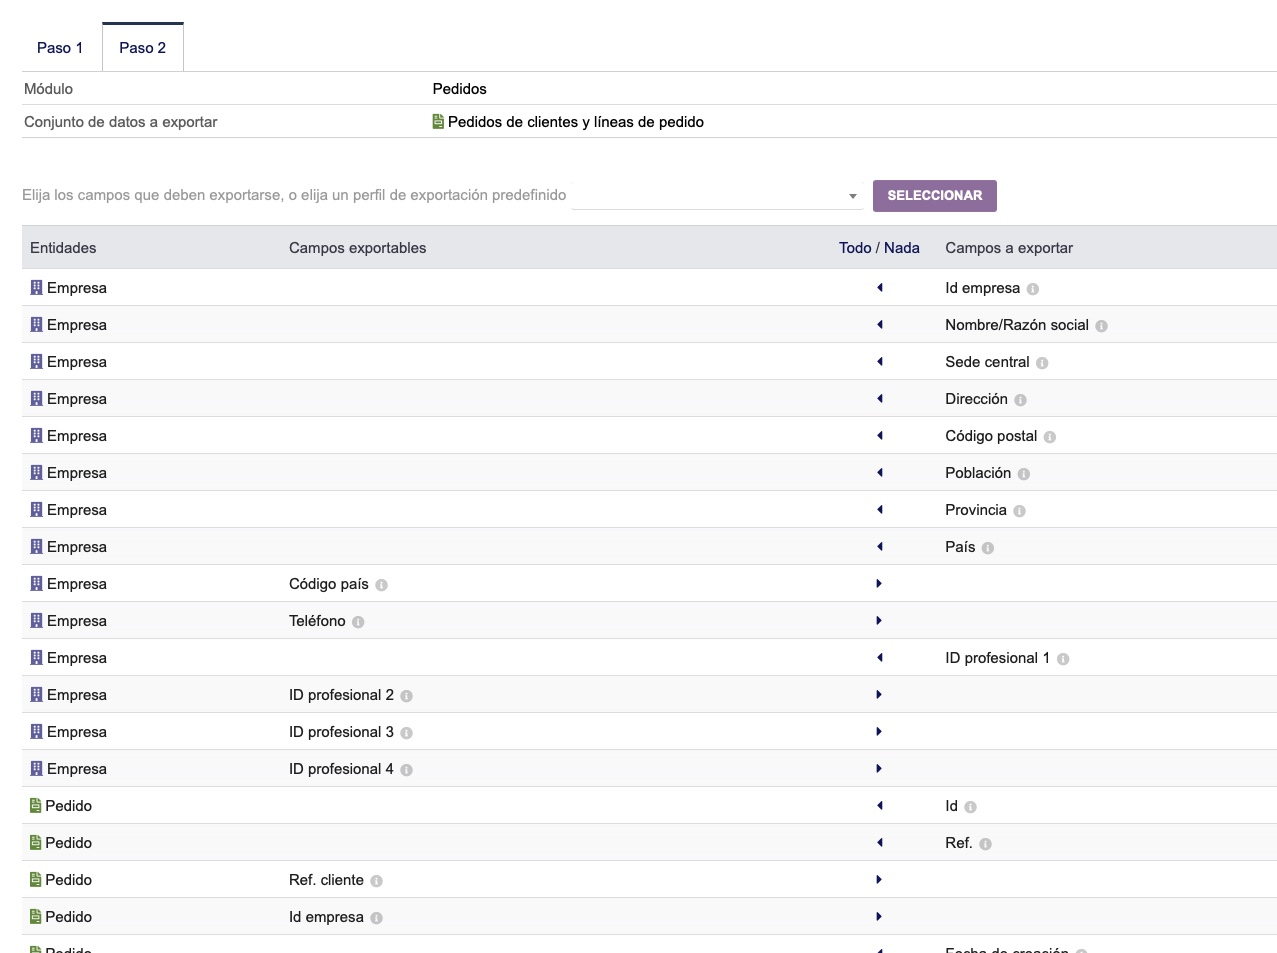

In [7]:
df = pd.read_excel("export_commande_1.xlsx")

# 2.  ANÁLISIS EXPLORATORIO DE LOS DATOS

In [8]:
EDA_inicial(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id empresa           1645 non-null   int64         
 1   Nombre/Razón social  1645 non-null   object        
 2   Dirección            1157 non-null   object        
 3   Código postal        1128 non-null   object        
 4   Población            1055 non-null   object        
 5   Provincia            680 non-null    object        
 6   País                 1645 non-null   object        
 7   Id                   1645 non-null   int64         
 8   Ref.                 1645 non-null   object        
 9   Fecha de creación    1645 non-null   datetime64[ns]
 10  Fecha de pedido      1645 non-null   datetime64[ns]
 11  Fecha de entrega     723 non-null    object        
 12  Total (Base imp).    1645 non-null   float64       
 13  Total                1645 non-nul

## 2.1 ANÁLISIS DE NULOS

In [9]:
df.isnull().sum()

Id empresa                0
Nombre/Razón social       0
Dirección               488
Código postal           517
Población               590
Provincia               965
País                      0
Id                        0
Ref.                      0
Fecha de creación         0
Fecha de pedido           0
Fecha de entrega        922
Total (Base imp).         0
Total                     0
Facturado                 0
Estado                    0
Sede central           1446
ID profesional 1       1297
dtype: int64

In [10]:
df.isnull().sum()/len(df)*100

Id empresa              0.000000
Nombre/Razón social     0.000000
Dirección              29.665653
Código postal          31.428571
Población              35.866261
Provincia              58.662614
País                    0.000000
Id                      0.000000
Ref.                    0.000000
Fecha de creación       0.000000
Fecha de pedido         0.000000
Fecha de entrega       56.048632
Total (Base imp).       0.000000
Total                   0.000000
Facturado               0.000000
Estado                  0.000000
Sede central           87.902736
ID profesional 1       78.844985
dtype: float64

## 2.2 ANÁLISIS DE DUPLICADOS

In [11]:
df.duplicated().sum()

0

## 2.3 SELECCIÓN DEL INDEX

Seleccionamos el ID de los pedidos como Index.

In [12]:
df.set_index("Id", inplace = True)

In [13]:
df.sample(1)

,Id empresa,Nombre/Razón social,Dirección,Código postal,Población,Provincia,País,Ref.,Fecha de creación,Fecha de pedido,Fecha de entrega,Total (Base imp).,Total,Facturado,Estado,Sede central,ID profesional 1
Id,,,,,,,,,,,,,,,,,
832,538,0.1.78 MARIA DE LA LUZ GONZALEZ,DR. VERTIZ 23,09480,Cdmx,Distrito Federal,Mexique,PROV832,2022-12-08 16:38:44,2022-12-08,2022-12-08 00:00:00,247.0,247.0,0,0,NaN,NaN


## 2.4 CONCLUSIONES SOBRE LA CALIDAD DE DATOS:

Tras un primer análisis exploratorio se concluye lo siguiente:

    1. Hay varias columnas con una elevada carga de valores nulos, debido a la ausencia de información en la fuente de información original. Como sabemos si estos nulos afectan a un grupo determinado de Clientes o Pedidos, en la fase de transoformación de la iformación, se investigará en mayor detalle.
    
      2. La información temporal tiene una de las 3 columnas en objeto, por lo que será necesaria su transformación.
      
      3. Sin prejuicio de lo señalado en los anteriores puntos, se considera que hay una Calidad de Dato suficiente para el Data Analysis y establecer el modelo de Machine Learning.
      
      




# 3. TRANSFORMACIÓN DE DATOS

Además de la habitual generación y transformación de variables, en este apartado se procederá de modo extraordinario a investigar la procedencia y posibles consecuencias de los valores nulos en el tratamiento posterior de información.

## 3.1 TRATAMIENTO DE VALORES NULOS

In [14]:
df_null = df

In [15]:
df_null.sample(1)

,Id empresa,Nombre/Razón social,Dirección,Código postal,Población,Provincia,País,Ref.,Fecha de creación,Fecha de pedido,Fecha de entrega,Total (Base imp).,Total,Facturado,Estado,Sede central,ID profesional 1
Id,,,,,,,,,,,,,,,,,
1738,357,AAAA LEONARDOBALZI,NaN,NaN,NaN,NaN,Italy,CO2304-0583,2023-04-05 20:10:52,2023-04-05,2023-04-05 00:00:00,76500.0,76500.0,0,1,NaN,NaN


In [16]:
df_postal = df_null.groupby(["Nombre/Razón social","Código postal"])["Código postal"].count()

In [17]:
df_postal_frame = df_postal.to_frame()

In [18]:
df_postal_frame.sample(10)

,,Código postal
Nombre/Razón social,Código postal,
HAUTECOEUR Yann,49000,2
BUROMIUM,42410,1
ORTEGA Charles - LG,49680,3
GUSTAVE MONOD,95880,1
Betsabé Flores,0000,1
MEDICAL CENTER,12042,1
Maximo Patrick,44800,1
Hanna Dove,10200,1
Yann.Hautecoeur,49000,1


In [19]:
df_postal_frame.to_excel("dfpostal.xlsx")

Se comprueba que no existe una relación entre estos nulos geográficos por el tipo de cliente o procedencia, por lo que no se harán exclusiones al respecto, se utilizará como valor primario de ubicación el país, y como valor secundario la provincia o Código Postal.

In [20]:
df = df.fillna(0)

## 3.2 TRATAMIENTO DE NOMBRES DUPLICADOS

Un error habitual en los ERP, es duplicar el nombre de un mismo cliente con errores ortográficos del tipon Manuel Fernández, MANUEL FERNÁNDEZ, etc....

Así que para tratar estos errores aplicamos el siguiente código.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 1 to 2518
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id empresa           1645 non-null   int64         
 1   Nombre/Razón social  1645 non-null   object        
 2   Dirección            1645 non-null   object        
 3   Código postal        1645 non-null   object        
 4   Población            1645 non-null   object        
 5   Provincia            1645 non-null   object        
 6   País                 1645 non-null   object        
 7   Ref.                 1645 non-null   object        
 8   Fecha de creación    1645 non-null   datetime64[ns]
 9   Fecha de pedido      1645 non-null   datetime64[ns]
 10  Fecha de entrega     1645 non-null   object        
 11  Total (Base imp).    1645 non-null   float64       
 12  Total                1645 non-null   float64       
 13  Facturado            1645 non-nul

In [22]:
df["Nombre/Razón social"] = df["Nombre/Razón social"].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1645 entries, 1 to 2518
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id empresa           1645 non-null   int64         
 1   Nombre/Razón social  1645 non-null   object        
 2   Dirección            1645 non-null   object        
 3   Código postal        1645 non-null   object        
 4   Población            1645 non-null   object        
 5   Provincia            1645 non-null   object        
 6   País                 1645 non-null   object        
 7   Ref.                 1645 non-null   object        
 8   Fecha de creación    1645 non-null   datetime64[ns]
 9   Fecha de pedido      1645 non-null   datetime64[ns]
 10  Fecha de entrega     1645 non-null   object        
 11  Total (Base imp).    1645 non-null   float64       
 12  Total                1645 non-null   float64       
 13  Facturado            1645 non-nul

In [23]:
df["Nombre/Razón social"] = df["Nombre/Razón social"].apply(lambda x: str(x))

In [24]:
df["Nombre/Razón social"] = df["Nombre/Razón social"].apply(lambda x: x.upper())

## 3.2 TRANSFORMACIÓN DE VARIABLES

Unicamente se transformará la fecha de entrega en Datetime.

In [25]:
#df["Fecha de entrega"] = pd.to_datetime(df["Fecha de entrega"])

## 3.3 CREACIÓN DE VARIABLES

Unicamente se crean columnas para el día mes y año nuevos.

In [26]:
df3 = df.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

In [27]:
df4 = df3.set_index("Fecha de creación")

In [28]:
df5 = atributos_fechas(df4)

In [29]:
df6 = df5.set_index("Id")

## 3.3 CREACIÓN DF DEFINITIVO PARA DA

In [30]:
df_merge_ba = pd.merge(left = df, right = df6, on = "Id", how = "outer")

In [31]:
df_merge_ba.shape

(1645, 38)

In [32]:
df.shape

(1645, 17)

In [33]:
df_merge_ba.columns

Index(['Id empresa_x', 'Nombre/Razón social_x', 'Dirección_x',
       'Código postal_x', 'Población_x', 'Provincia_x', 'País_x', 'Ref._x',
       'Fecha de creación', 'Fecha de pedido_x', 'Fecha de entrega_x',
       'Total (Base imp)._x', 'Total_x', 'Facturado_x', 'Estado_x',
       'Sede central_x', 'ID profesional 1_x', 'Id empresa_y',
       'Nombre/Razón social_y', 'Dirección_y', 'Código postal_y',
       'Población_y', 'Provincia_y', 'País_y', 'Ref._y', 'Fecha de pedido_y',
       'Fecha de entrega_y', 'Total (Base imp)._y', 'Total_y', 'Facturado_y',
       'Estado_y', 'Sede central_y', 'ID profesional 1_y', 'año', 'mes',
       'dia_mes', 'dia_semana', 'hora'],
      dtype='object')

In [34]:
df_merge_ba.drop(['Id empresa_y',
       'Nombre/Razón social_y', 'Dirección_y', 'Código postal_y',
       'Población_y', 'Provincia_y', 'País_y', 'Ref._y', 'Fecha de pedido_y',
       'Fecha de entrega_y', 'Total (Base imp)._y', 'Total_y', 'Facturado_y',
       'Estado_y', 'Sede central_y', 'ID profesional 1_y',], axis = 1, inplace = True)

In [35]:
df_merge_ba

,Id empresa_x,Nombre/Razón social_x,Dirección_x,Código postal_x,Población_x,Provincia_x,País_x,Ref._x,Fecha de creación,Fecha de pedido_x,...,Total_x,Facturado_x,Estado_x,Sede central_x,ID profesional 1_x,año,mes,dia_mes,dia_semana,hora
Id,,,,,,,,,,,,,,,,,,,,,
1,1,INDIAN SAS,1 alalah road,0,Delhi,0,France,CO1107-0002,2013-07-20 15:23:12,2022-07-20,...,10.00,0,1,0,123456789,2013,July,20,Saturday,15
2,1,INDIAN SAS,1 alalah road,0,Delhi,0,France,CO1107-0003,2013-07-20 23:20:12,2022-07-21,...,10.00,0,1,0,123456789,2013,July,20,Saturday,23
3,1,INDIAN SAS,1 alalah road,0,Delhi,0,France,CO1107-0004,2013-07-20 23:22:53,2022-07-21,...,30.00,0,1,0,123456789,2013,July,20,Saturday,23
5,1,INDIAN SAS,1 alalah road,0,Delhi,0,France,CO1108-0001,2013-08-08 03:04:11,2022-08-08,...,10.00,0,2,0,123456789,2013,August,8,Thursday,3
47,1,INDIAN SAS,1 alalah road,0,Delhi,0,France,CO7001-0013,2017-02-16 00:05:11,2021-11-13,...,55.00,0,1,0,123456789,2017,February,16,Thursday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,1971,KUMAFOURNISSEUR,kumaAdresse,75000,PARIS,0,France,PROV2430,2023-06-01 17:15:03,2023-06-01,...,25.00,0,0,0,Drummer,2023,June,1,Thursday,17
2460,1988,LANPU,"LINGANG,SH,CN",0,上海,0,China,CO2306-0915,2023-06-07 12:27:58,2023-06-07,...,2350.00,0,1,0,0,2023,June,7,Wednesday,12
2463,1990,DELLAMORASPA,VIA ZOCCOLA 23,0,0,0,Italy,CO2306-0916,2023-06-07 23:16:47,2023-06-07,...,19968.00,0,1,0,0,2023,June,7,Wednesday,23


Comprobamos que el número de filas es el mismo y exportamos a excel el archivo para el Data Analysis en PBI

In [36]:
df_merge_ba.to_excel("dfpostal.xlsx")

In [37]:
df_merge_ba.sample(1)

,Id empresa_x,Nombre/Razón social_x,Dirección_x,Código postal_x,Población_x,Provincia_x,País_x,Ref._x,Fecha de creación,Fecha de pedido_x,...,Total_x,Facturado_x,Estado_x,Sede central_x,ID profesional 1_x,año,mes,dia_mes,dia_semana,hora
Id,,,,,,,,,,,,,,,,,,,,,
334,193,SUNNYWORKS,Bangalore,562012,Bangalore,0,India,PROV334,2022-09-26 10:21:38,2022-09-26,...,17940.0,0,0,0,0,2022,September,26,Monday,10


In [38]:
x = df_merge_ba.groupby("Nombre/Razón social_x")["Total_x"].sum()
x = x.to_frame()

In [39]:
y = df_merge_ba.groupby("Nombre/Razón social_x")["Total_x"].count()
y = y.to_frame()

In [40]:
clientes_merge = pd.merge(left = x, right = y, on = "Nombre/Razón social_x", how = "outer")

In [41]:
clientes_merge = clientes_merge.rename(columns={"Total_x_x":"Facturación",
                                   "Total_x_y":"Pedidos"})

In [42]:
clientes_merge = clientes_merge.rename(columns={"Nombre/Razón social_x":"Cliente",})

In [43]:
clientes_merge_v = clientes_merge.reset_index()

In [44]:
clientes_merge_v

,Nombre/Razón social_x,Facturación,Pedidos
0,!SK MARSEILLE,73205.68,25
1,+_,179.40,2
2,"0,1 JUPITEC",24140723.42,163
3,0.1. ALEJANDRO PEREZ MORENO,3974029.36,83
4,0.1.2 ALEJANDRO BOTELLO,84642961.48,38
...,...,...,...
451,YTS TEST,10.00,1
452,ZECON OIL,270.00,1
453,ZENZA TRADERS,33.48,1
454,ZZZZ,79854.42,20


In [45]:
clientes_merge_v["Promedio"] = clientes_merge_v["Facturación"]/clientes_merge_v["Pedidos"]


In [46]:
clientes_merge_v

,Nombre/Razón social_x,Facturación,Pedidos,Promedio
0,!SK MARSEILLE,73205.68,25,2.928227e+03
1,+_,179.40,2,8.970000e+01
2,"0,1 JUPITEC",24140723.42,163,1.481026e+05
3,0.1. ALEJANDRO PEREZ MORENO,3974029.36,83,4.787987e+04
4,0.1.2 ALEJANDRO BOTELLO,84642961.48,38,2.227446e+06
...,...,...,...,...
451,YTS TEST,10.00,1,1.000000e+01
452,ZECON OIL,270.00,1,2.700000e+02
453,ZENZA TRADERS,33.48,1,3.348000e+01
454,ZZZZ,79854.42,20,3.992721e+03


In [47]:
px.strip(data_frame =clientes_merge_v,
         x          = "Promedio",
         y          = "Facturación",
         color      = "Nombre/Razón social_x")

In [48]:
clientes_merge_T = clientes_merge.T

In [49]:
clientes_merge_T

Nombre/Razón social_x,!SK MARSEILLE,+_,"0,1 JUPITEC",0.1. ALEJANDRO PEREZ MORENO,0.1.2 ALEJANDRO BOTELLO,0.1.3 ABEL DOMINGUEZ,0.1.6.8 BONAFONT,0.1.78 MARIA DE LA LUZ GONZALEZ,0.1.8 ROBERTO ALCAZAR,0.1.90 SORIANA,...,YANN.HAUTECOEUR,YM BUSSINES SERVICES,YOUPILAND,YOUSSRA,YOYOS,YTS TEST,ZECON OIL,ZENZA TRADERS,ZZZZ,ÉTHAN DELL
Facturación,73205.68,179.4,24140723.42,3974029.36,84642961.48,201771.27,29094.98,1079372.33,17574.74,461258.63,...,1110.65,21240.0,1000.0,18000.0,725.0,10.0,270.0,33.48,79854.42,440.22
Pedidos,25.00,2.0,163.00,83.00,38.00,31.00,22.00,21.00,20.00,10.00,...,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.00,20.00,1.00


In [50]:
clientes_merge.iplot(kind = "scatter", mode = "markers", x = "Facturación", y = "Pedidos"
                    )

# 4. DATA ANALYSIS 

A continuación se presentan las principales conclusiones tras en análisis realizado en Power BI.



# 5. MACHINE LEARNING

En primer lugar se realiza una copia de la base de datos para evitar su alteración.

In [51]:
df_ml = df_merge_ba.copy()

## 5.1 Tratamiento de variables numéricas y categóricas

In [52]:
df_num = df_ml._get_numeric_data().copy()

In [53]:
df_cat = df_ml.drop(df_num.columns, axis = 1)

In [54]:
df_num.sample(1)

,Id empresa_x,Total (Base imp)._x,Total_x,Facturado_x,Estado_x,año,dia_mes,hora
Id,,,,,,,,
457,227,30.0,30.3,0,1,2022,14,9


In [55]:
df_cat.sample(1)

,Nombre/Razón social_x,Dirección_x,Código postal_x,Población_x,Provincia_x,País_x,Ref._x,Fecha de creación,Fecha de pedido_x,Fecha de entrega_x,Sede central_x,ID profesional 1_x,mes,dia_semana
Id,,,,,,,,,,,,,,
1376,123123,0,0,0,0,India,CO2302-0468,2023-02-18 06:29:04,2023-02-18,0,0,0,February,Saturday


Antes de continuar procedemos a eliminar algunas columnas que no aportan valor tras su exploración en la fase de Data Analysis.

In [56]:
df_cat.drop(['Dirección_x',
       'Población_x', 'Ref._x', 'Sede central_x',
       'ID profesional 1_x'], axis = 1, inplace = True)

Ahora las unimos

In [57]:
df_merge_ml = pd.merge(left = df_num, right = df_cat, on = "Id", how = "outer")

In [58]:
df_merge_ml.sample(1)

,Id empresa_x,Total (Base imp)._x,Total_x,Facturado_x,Estado_x,año,dia_mes,hora,Nombre/Razón social_x,Código postal_x,Provincia_x,País_x,Fecha de creación,Fecha de pedido_x,Fecha de entrega_x,mes,dia_semana
Id,,,,,,,,,,,,,,,,,
1756,538,18108.05,18108.05,0,1,2023,8,8,0.1.78 MARIA DE LA LUZ GONZALEZ,09480,Distrito Federal,Mexique,2023-04-08 08:57:44,2023-04-08,2023-04-20 00:00:00,April,Saturday


In [59]:
dfkmeans =clientes_merge_v.iloc[:,1:3]
dfkmeans.sample(1)

,Facturación,Pedidos
158,120.0,1


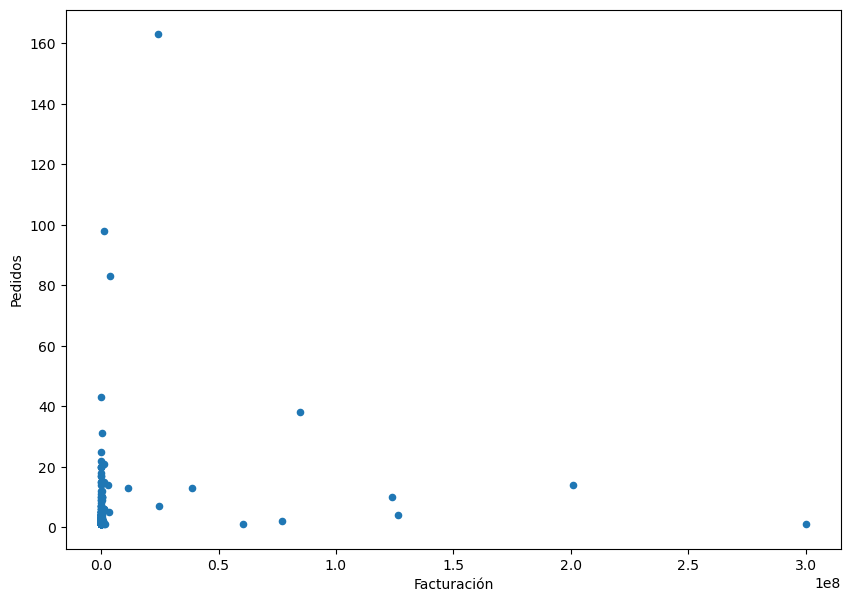

In [60]:
dfkmeans.plot(kind="scatter",
        x="Facturación",
        y="Pedidos",
        figsize=(10, 7))
plt.show()

### Número de Clusters con el Método Elbow

In [61]:
sum_of_sqr_dist = {}

for k in range(1, 10):
    km = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    km = km.fit(dfkmeans)
    sum_of_sqr_dist[k] = km.inertia_

In [62]:
sum_of_sqr_dist

{1: 1.7850665276129136e+17,
 2: 3.995603346179285e+16,
 3: 1.1179466603753112e+16,
 4: 6257391533801306.0,
 5: 2601717794364129.5,
 6: 620479135204418.9,
 7: 339857655878818.4,
 8: 205616547908156.88,
 9: 80315684954849.98}

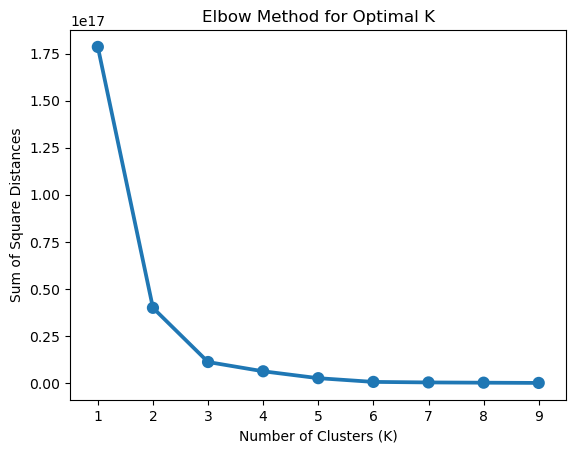

In [63]:
sns.pointplot(x=list(sum_of_sqr_dist.keys()), y=list(sum_of_sqr_dist.values()))
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Square Distances")
plt.title("Elbow Method for Optimal K")
plt.show()

### K-Means Clustering

In [64]:
Model = KMeans(n_clusters=5,
             init='k-means++',
             max_iter=1000)
Model.fit(dfkmeans)

KMeans(max_iter=1000, n_clusters=5)

In [65]:
print("Labels", Model.labels_)

Labels [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [66]:
print("Centroids", Model.cluster_centers_)

Centroids [[1.99360275e+05 3.48660714e+00]
 [2.00782309e+08 1.40000000e+01]
 [6.51312047e+07 1.35000000e+01]
 [3.00000000e+08 1.00000000e+00]
 [1.25024066e+08 7.00000000e+00]]


In [67]:
centroids = Model.cluster_centers_

In [68]:
df1_cluster = dfkmeans.copy()
df1_cluster["Cluster"] = Model.fit_predict(dfkmeans)

In [69]:
df1_cluster.head()

,Facturación,Pedidos,Cluster
0,73205.68,25,0
1,179.40,2,0
2,24140723.42,163,0
3,3974029.36,83,0
4,84642961.48,38,2


In [70]:
Color = ['red', 'blue', 'black', 'gold', 'navy']
df1_cluster['Color'] = df1_cluster['Cluster'].map(lambda p:Color[p])

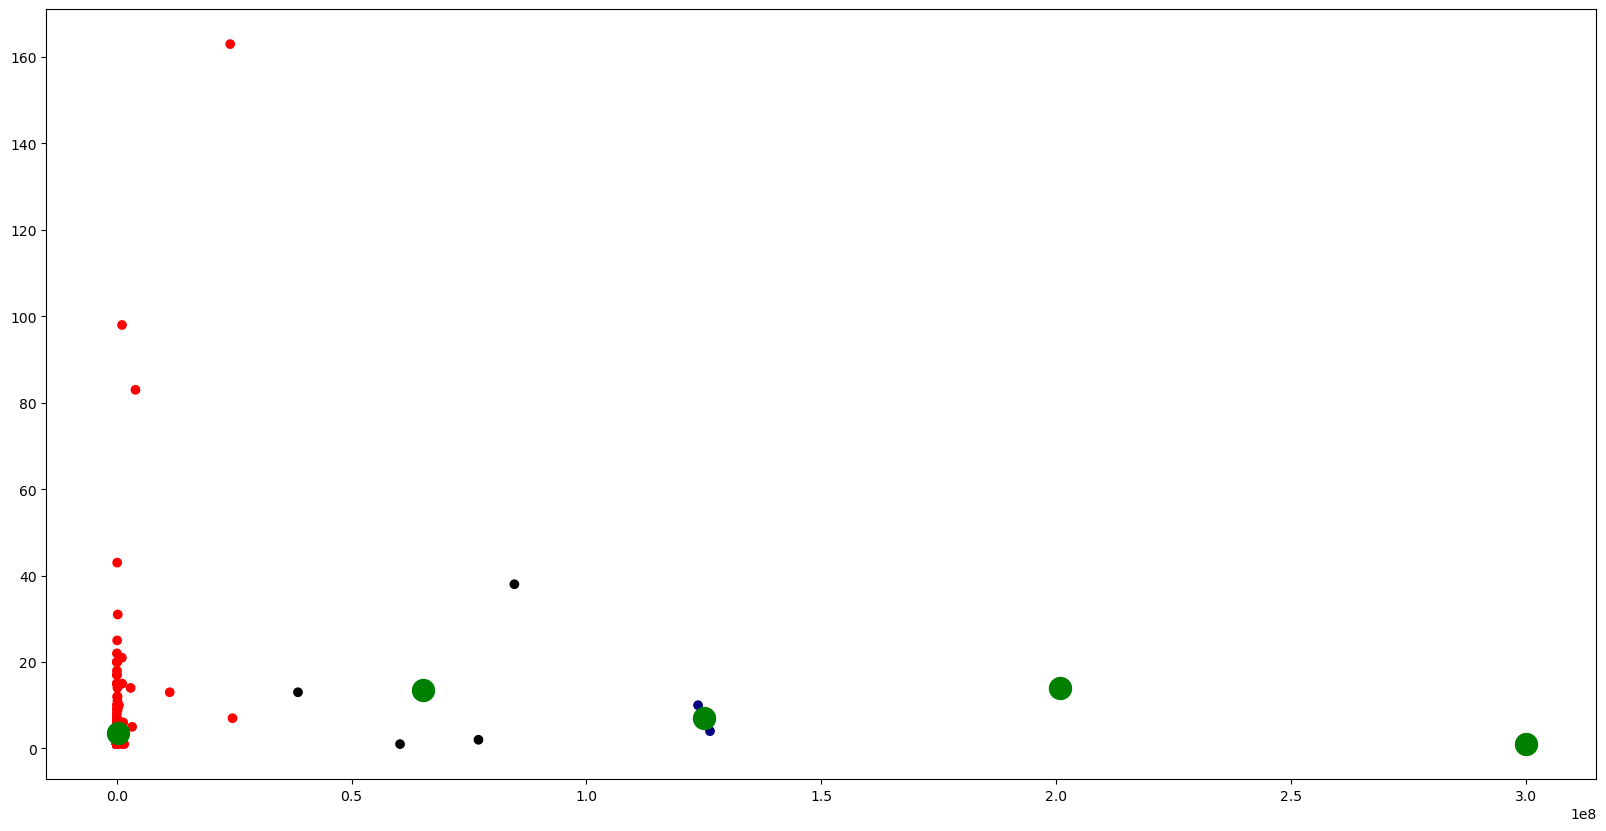

In [71]:
plt.figure(figsize=(20, 10))
plt.scatter(dfkmeans["Facturación"],
           dfkmeans["Pedidos"],
           c=df1_cluster["Color"])

plt.scatter(centroids[:, 0], centroids[:, 1], c='green', s=250)
plt.show()